In [9]:
# ruff: noqa
import sys, os
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))

# ruff: noqa
from feedback_grape.fgrape import evaluate_on_longer_time
from helpers import (
    generate_excited_state,
    init_grape_protocol,
    init_fgrape_protocol,
    test_implementations,
    generate_random_discrete_state,
    generate_random_bloch_state,
    generate_excited_state,
    generate_ground_state,
)
from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import json

test_implementations()

jax.config.update("jax_enable_x64", True)

# Physical parameters
# (attention! #elements in density matrix grow as 4^N_chains)
N_chains = 3 # Number of parallel chains to simulate
gamma = 0.05 # Decay constant
generate_state = generate_random_discrete_state
evaluation_time_steps = 200 # Number of time steps for evaluation
batch_size = 32 # Number of random states to evaluate in parallel

filenames = [
    "lut_t=2_l=2_w=11_noise=0.0_s=0_trained_on_bloch_sphere.json",
    "lut_t=3_l=2_w=111_noise=0.0_s=1_trained_on_bloch_sphere.json",
    "lut_t=3_l=2_w=111_noise=0.0_s=2_trained_on_discrete_states.json",
    "lut_t=3_l=2_w=111_noise=0.0_s=1_trained_on_bloch_sphere_high_decay.json",
    "lut_t=3_l=2_w=111_noise=0.0_s=2_trained_on_discrete_states_high_decay.json",
]

In [10]:
all_results = []
for filename in filenames:
    with open(f"./optimized/{filename}", "r") as f:
        lut = json.load(f)["optimized_trainable_parameters"]

    system_params = init_fgrape_protocol(jax.random.PRNGKey(0), N_chains, gamma)

    pure_state = lambda key: generate_state(key, N_chains=N_chains, noise_level=0.0)

    eval_result = evaluate_on_longer_time( # Evaluate on longer time and choose best LUT accordingly
        U_0 = pure_state,
        C_target = pure_state,
        system_params = system_params,
        optimized_trainable_parameters = lut,
        num_time_steps = evaluation_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = batch_size,
        mode = "lookup",
    )
    fidelities = eval_result.fidelity_each_timestep
    all_results.append(eval_result)

    np.savez(f"./results_discrete_states/{filename[:-5]}.npz", fidelities=fidelities)

In the code below, one can plot how an observable behaves on the batch

In [11]:
from feedback_grape.utils.operators import sigmap, sigmam, sigmax, sigmay, sigmaz, identity # type: ignore
import jax.numpy as jnp
import jax
from library.utils.qubit_chain_1D import embed
from matplotlib import pyplot as plt

observables = [
    embed(sigmax(), 0, N_chains),
    embed(sigmax(), 1, N_chains),
    embed(sigmax(), 2, N_chains),
    embed(sigmay(), 0, N_chains),
    embed(sigmay(), 1, N_chains),
    embed(sigmay(), 2, N_chains),
    embed(sigmaz(), 0, N_chains),
    embed(sigmaz(), 1, N_chains),
    embed(sigmaz(), 2, N_chains),
]
obs_values = np.zeros((len(observables), len(all_results), evaluation_time_steps+1, batch_size))
purity_values = np.zeros((len(all_results), evaluation_time_steps+1, batch_size))

for r,result in enumerate(all_results):
    for t, rho_batch in enumerate(result.state_each_timestep):
        for o,obs in enumerate(observables):
            vals = jax.vmap(lambda rho: jnp.real(jnp.trace(rho @ obs)))(rho_batch)

            obs_values[o, r, t, :] = vals
        purity_vals = jax.vmap(lambda rho: jnp.real(jnp.trace(rho @ rho)))(rho_batch)
        purity_values[r, t, :] = purity_vals

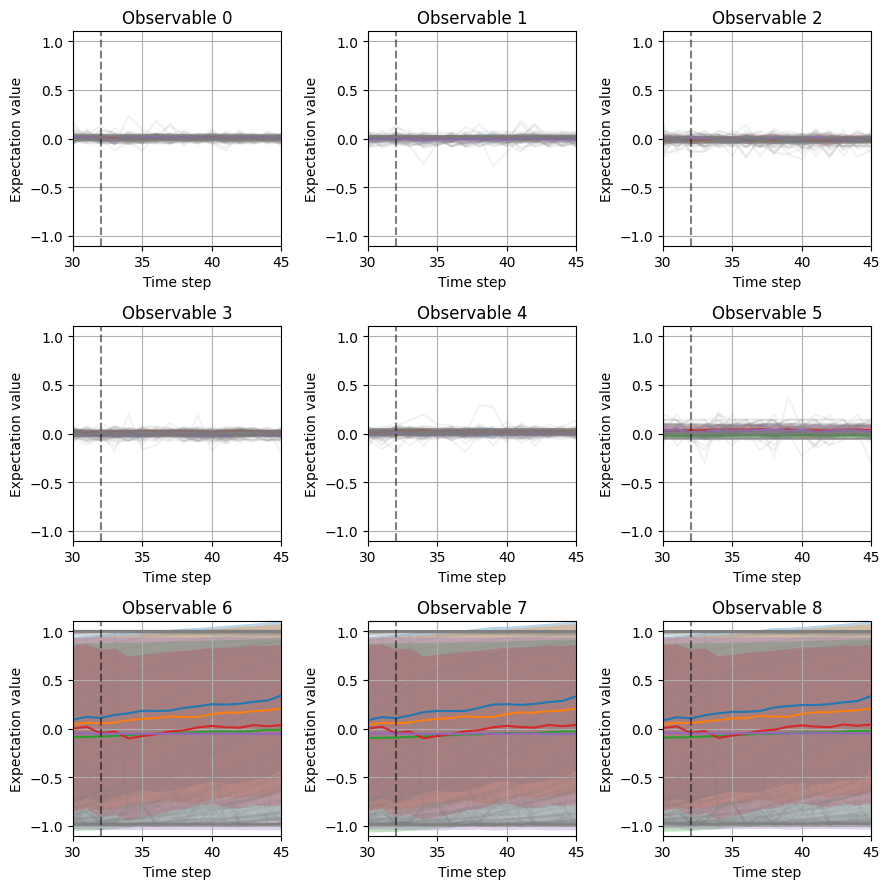

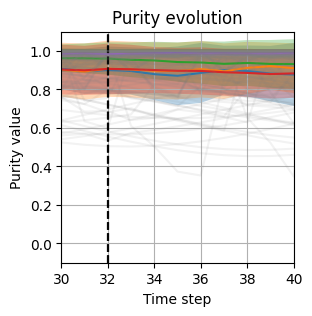

In [12]:
# Plot time evolution of observables
fig, axs = plt.subplots(3,3, figsize=(9,9))
axs = axs.flatten()
for o in range(len(observables)):
    for r in range(len(all_results)):
        axs[o].plot((obs_values[o, r, :, :]).mean(axis=1), alpha=1)
        axs[o].fill_between(
            np.arange(evaluation_time_steps+1),
            (obs_values[o, r, :, :]).mean(axis=1) - (obs_values[o, r, :, :]).std(axis=1),
            (obs_values[o, r, :, :]).mean(axis=1) + (obs_values[o, r, :, :]).std(axis=1),
            alpha=0.3
        )
        axs[o].plot(obs_values[o, r, :, :], alpha=0.1, color='gray')

    axs[o].grid()
    axs[o].set_xlabel("Time step")
    axs[o].set_ylabel("Expectation value")
    axs[o].set_title(f"Observable {o}")
    axs[o].set_ylim([-1.1, 1.1])
    axs[o].set_xlim(30, 45)
    axs[o].axvline(32, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot time evolution of purities
fig, ax = plt.subplots(1,1, figsize=(3,3))
for r,result in enumerate(all_results):
    ax.plot(purity_values[r, :, :].mean(axis=1), label=f"Experiment {r}")
    ax.fill_between(
        np.arange(evaluation_time_steps+1),
        purity_values[r, :, :].mean(axis=1) - purity_values[r, :, :].std(axis=1),
        purity_values[r, :, :].mean(axis=1) + purity_values[r, :, :].std(axis=1),
        alpha=0.3
    )
    ax.plot(purity_values[r, :, :], alpha=0.1, color='gray')

    ax.grid()
    ax.set_xlabel("Time step")
    ax.set_ylabel("Purity value")
    ax.set_title(f"Purity evolution")
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlim(30, 40)
    ax.axvline(32, color='black', linestyle='--', alpha=0.5)